In [1]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
import numpy as np
import random
import tensorflow as tf

# 1. 파이썬 랜덤
random.seed(42)

# 2. 넘파이 랜덤
np.random.seed(42)

# 3. 텐서플로 랜덤
tf.random.set_seed(42)

In [3]:
import pandas as pd
df = pd.read_csv('/content/exchange_final.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     300 non-null    int64  
 1   TIME           300 non-null    object 
 2   원/달러환율         300 non-null    float64
 3   한국 장기 시장 금리    291 non-null    float64
 4   미국 장기 시장 금리    300 non-null    float64
 5   중국 장기 시장 금리    132 non-null    float64
 6   한국 단기 시장 금리    300 non-null    float64
 7   미국 단기 시장 금리    299 non-null    float64
 8   중국 단기 시장 금리    299 non-null    float64
 9   전체 수출 총액       300 non-null    int64  
 10  미국 수출 총액       300 non-null    int64  
 11  중국 수출 총액       300 non-null    int64  
 12  전체 수입 총액       300 non-null    int64  
 13  미국 수입 총액       300 non-null    int64  
 14  중국 수입 총액       300 non-null    int64  
 15  소득 교역 조건 지수    300 non-null    float64
 16  해외 직접 투자 금액    300 non-null    int64  
 17  경제 심리 지수       264 non-null    float64
 18  한국 기준 금리  

In [4]:
df_fill = df.interpolate(method='linear')
df_fill = df_fill.fillna(method='ffill').fillna(method='bfill')

<ipython-input-4-e6a07bd6edf8>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_fill = df.interpolate(method='linear')
<ipython-input-4-e6a07bd6edf8>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fill = df_fill.fillna(method='ffill').fillna(method='bfill')


In [6]:
df_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     300 non-null    int64  
 1   TIME           300 non-null    object 
 2   원/달러환율         300 non-null    float64
 3   한국 장기 시장 금리    300 non-null    float64
 4   미국 장기 시장 금리    300 non-null    float64
 5   중국 장기 시장 금리    300 non-null    float64
 6   한국 단기 시장 금리    300 non-null    float64
 7   미국 단기 시장 금리    300 non-null    float64
 8   중국 단기 시장 금리    300 non-null    float64
 9   전체 수출 총액       300 non-null    int64  
 10  미국 수출 총액       300 non-null    int64  
 11  중국 수출 총액       300 non-null    int64  
 12  전체 수입 총액       300 non-null    int64  
 13  미국 수입 총액       300 non-null    int64  
 14  중국 수입 총액       300 non-null    int64  
 15  소득 교역 조건 지수    300 non-null    float64
 16  해외 직접 투자 금액    300 non-null    int64  
 17  경제 심리 지수       300 non-null    float64
 18  한국 기준 금리  

## shift된 t+1 예측

In [5]:
features = [
    '경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
    '한국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
    '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격',
    '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '외국인 투자 금액',
    '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', '실질GDP',
    '실질GDP성장률', '한국 10년 채권수익률', '미국 10년 채권수익률', 'vix'
]

# 타겟 생성
df_fill['원/달러환율_t+1'] = df_fill['원/달러환율'].shift(-1)

# 타겟
target = ['원/달러환율_t+1']

# X, y 나누기 전에 결측치 제거
df_fill = df_fill.dropna(subset=features + ['원/달러환율_t+1']).reset_index(drop=True)

In [6]:
# X(입력값) 과 y(타겟값) 을 나눔
X = df_fill[features]
y = df_fill['원/달러환율_t+1']

### 시퀀스 생성


"최근 12개월" 데이터를 입력으로 주고 → "그 다음 달" 환율을 예측

In [41]:
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])  # seq_length 길이만큼 입력
        ys.append(y[i+seq_length])    # seq_length 이후 값을 타겟으로
    return np.array(Xs), np.array(ys)

seq_length = 12
X_seq, y_seq = create_sequences(X.values, y.values, seq_length)


### 훈련/ 테스트 분할

- 시계열이니 shuffle 없이

- 시간 순서 유지하면서 8:2로 분리

In [42]:
split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

### 정규화 MinMaxScaler()

In [43]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [44]:
# 1. X_train 스케일링
nsamples, timesteps, nfeatures = X_train_raw.shape
X_train_2d = X_train_raw.reshape((nsamples * timesteps, nfeatures))
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape((nsamples, timesteps, nfeatures))

# 2. y_train 스케일링
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

# 3. X_test 스케일링
nsamples_test, timesteps, nfeatures = X_test_raw.shape
X_test_2d = X_test_raw.reshape((nsamples_test * timesteps, nfeatures))
X_test_scaled_2d = scaler_X.transform(X_test_2d)  # X_test는 transform만 사용
X_test_scaled = X_test_scaled_2d.reshape((nsamples_test, timesteps, nfeatures))

# 4. y_test 스케일링
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

### GRU 모델

In [12]:
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.1), # 과적합 방지
    GRU(32),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam') # 회귀문제 mse

# validation_loss가 10 epoch 동안 개선 안되면 자동 종료하고 최적 모델 복구
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.1047 - val_loss: 0.0312
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0344 - val_loss: 0.0709
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0163 - val_loss: 0.0307
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0115 - val_loss: 0.0353
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0099 - val_loss: 0.0256
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092 - val_loss: 0.0148
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0094 - val_loss: 0.0137
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - val_loss: 0.0135
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0119
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072 - val_loss: 0.0109
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

### 예측 및 복원

예측값을 다시 원래 단위(환율)로 복구

In [13]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step


### 성능 평가

In [14]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 결과 출력
print("✅ 성능 평가 결과")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

✅ 성능 평가 결과
MSE: 11752.6305
RMSE: 108.4095
MAE: 91.2190
R²: -0.3498


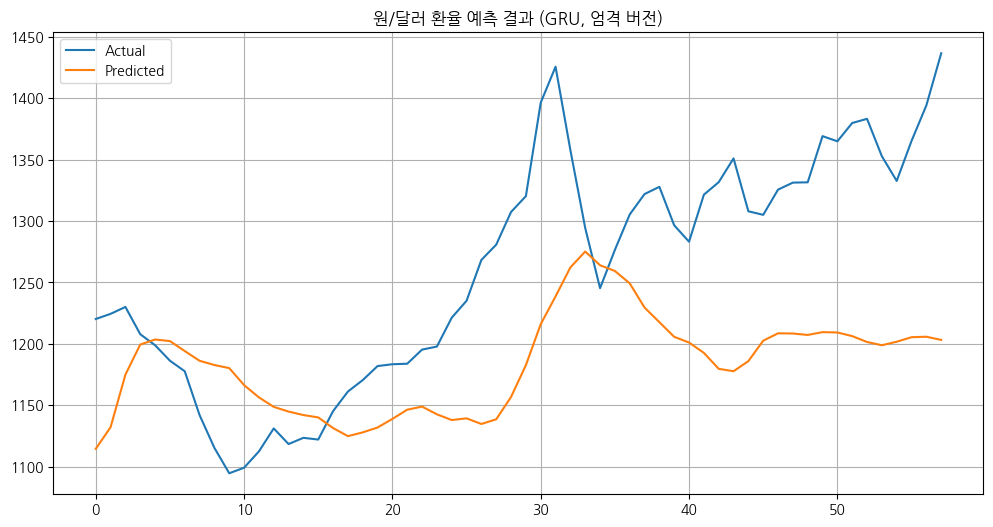

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("원/달러 환율 예측 결과 (GRU, 엄격 버전)")
plt.legend()
plt.grid(True)
plt.show()

### 모델 개선

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional

model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    GRU(16),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')

# validation_loss가 10 epoch 동안 개선 안되면 자동 종료하고 최적 모델 복구
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0756 - val_loss: 0.0287
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0266 - val_loss: 0.0139
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0176 - val_loss: 0.0059
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0058 - val_loss: 0.0168
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0

In [18]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


In [19]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 결과 출력
print("✅ 성능 평가 결과")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

✅ 성능 평가 결과
MSE: 9728.5623
RMSE: 98.6335
MAE: 83.7983
R²: -0.1173


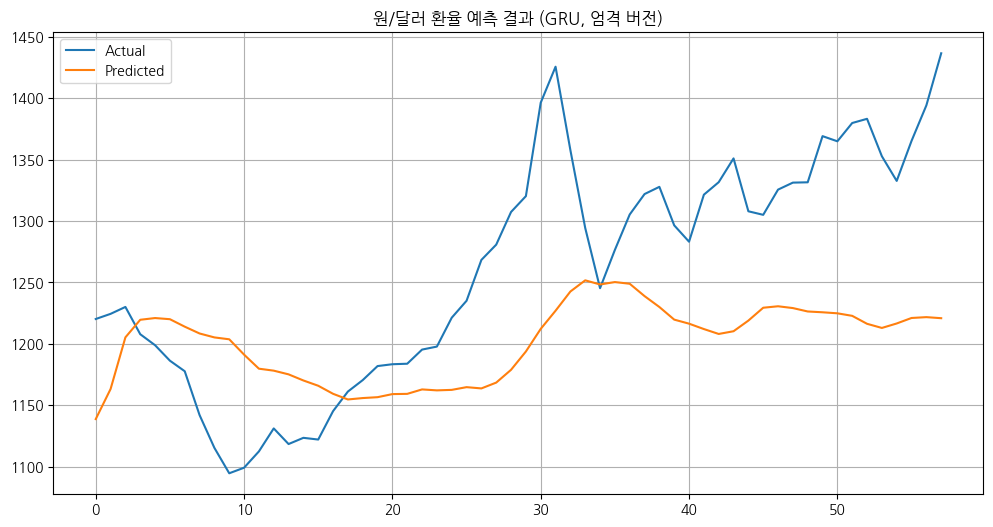

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("원/달러 환율 예측 결과 (GRU, 엄격 버전)")
plt.legend()
plt.grid(True)
plt.show()

## 전진선택법으로 피처 선택

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 준비
df = pd.read_csv('/content/exchange_final.csv')  # 파일 경로 맞춰줘
df_fill = df.interpolate(method='linear')
df_fill = df_fill.fillna(method='ffill').fillna(method='bfill')

# 2. 피처, 타겟 정의
all_features = [
    '경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
    '한국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
    '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격',
    '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '외국인 투자 금액',
    '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', '실질GDP',
    '실질GDP성장률', '한국 10년 채권수익률', '미국 10년 채권수익률', 'vix'
]

# 타겟 생성
df_fill['원/달러환율_t+1'] = df_fill['원/달러환율'].shift(-1)
df_fill = df_fill.dropna(subset=all_features + ['원/달러환율_t+1']).reset_index(drop=True)
target = '원/달러환율_t+1'

# 3. 시퀀스 생성 함수
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# 4. 전진 선택법
selected_features = []
best_r2 = -np.inf

while True:
    candidates = list(set(all_features) - set(selected_features))
    improvement = False
    best_candidate = None
    best_candidate_r2 = -np.inf

    for feature in candidates:
        current_features = selected_features + [feature]

        # 데이터 준비
        X = df_fill[current_features]
        y = df_fill[target]

        # 시퀀스 생성
        seq_length = 12
        X_seq, y_seq = create_sequences(X.values, y.values, seq_length)

        # 학습/테스트 분리
        split = int(len(X_seq) * 0.8)
        X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
        y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

        # 스케일링
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        nsamples, timesteps, nfeatures = X_train_raw.shape
        X_train_2d = X_train_raw.reshape((nsamples * timesteps, nfeatures))
        X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, nfeatures))
        y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

        nsamples_test, _, _ = X_test_raw.shape
        X_test_2d = X_test_raw.reshape((nsamples_test * timesteps, nfeatures))
        X_test_scaled = scaler_X.transform(X_test_2d).reshape((nsamples_test, timesteps, nfeatures))
        y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

        # 모델 정의
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
            Dropout(0.2),
            GRU(32, return_sequences=True),
            Dropout(0.2),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])

        model.compile(loss='mse', optimizer='adam')

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_scaled, y_train_scaled,
            epochs=30, batch_size=16,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0
        )

        # 평가
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_scaled)

        r2 = r2_score(y_true, y_pred)

        if r2 > best_candidate_r2:
            best_candidate_r2 = r2
            best_candidate = feature

    if best_candidate_r2 > best_r2:
        selected_features.append(best_candidate)
        best_r2 = best_candidate_r2
        print(f"✅ 추가된 피처: {best_candidate}, 현재 R²: {best_r2:.4f}")
        improvement = True
    else:
        break

print("\n🎯 최종 선택된 피처 리스트:")
for f in selected_features:
    print(f"- {f}")
print(f"\n📈 최종 R²: {best_r2:.4f}")

✅ 추가된 피처: 소맥 가격, 현재 R²: 0.0895
✅ 추가된 피처: 옥수수 가격, 현재 R²: 0.1104
✅ 추가된 피처: 철광석 가격, 현재 R²: 0.1137

🎯 최종 선택된 피처 리스트:
- 소맥 가격
- 옥수수 가격
- 철광석 가격

📈 최종 R²: 0.1137



🎯 최종 모델 성능
R²: -1.9054
RMSE: 159.0510
MSE: 25297.2171
MAE: 133.8555


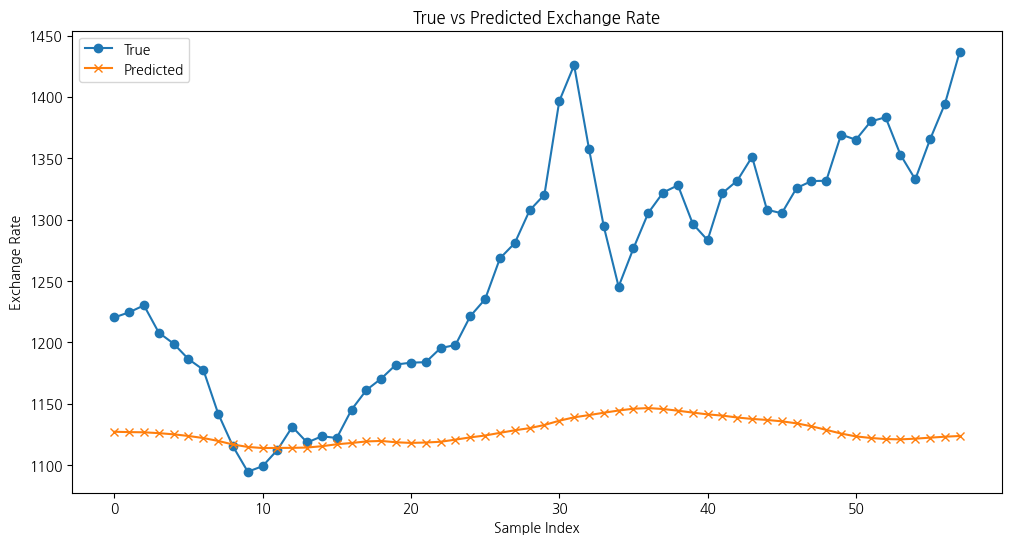

In [25]:
# ======= 전진 선택법 끝나고 추가 =======

# 최종 선택된 feature만으로 다시 학습
final_features = selected_features.copy()

# 데이터 준비
X = df_fill[final_features]
y = df_fill[target]

# 시퀀스 생성
seq_length = 12
X_seq, y_seq = create_sequences(X.values, y.values, seq_length)

# 학습/테스트 분리
split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

nsamples, timesteps, nfeatures = X_train_raw.shape
X_train_2d = X_train_raw.reshape((nsamples * timesteps, nfeatures))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, nfeatures))
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

nsamples_test, _, _ = X_test_raw.shape
X_test_2d = X_test_raw.reshape((nsamples_test * timesteps, nfeatures))
X_test_scaled = scaler_X.transform(X_test_2d).reshape((nsamples_test, timesteps, nfeatures))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 모델 재정의
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    GRU(16),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=30, batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# 예측
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# 성능 지표 계산
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n🎯 최종 모델 성능")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# 예측 vs 실제 그래프
plt.figure(figsize=(12,6))
plt.plot(y_true, label='True', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('True vs Predicted Exchange Rate')
plt.xlabel('Sample Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


### 업그레이드

- Validation set 고정: feature 추가할 때 매번 새롭게 학습 & 고정된 검증셋에서 평가

- 최종 모델 평가: 따로 분리된 Test set 기준으로 최종 성능 평가

- EarlyStopping 강화: patience=3, epochs=20 → 과적합 방지 & 빠른 수렴

- Random Seed 고정: 완벽히 고정 (Python, Numpy, Tensorflow)

✅ 추가된 피처: 실질GDP성장률, 현재 R²: 0.7003
✅ 추가된 피처: 한국 경상수지, 현재 R²: 0.7639
✅ 추가된 피처: 한국 실업률, 현재 R²: 0.8045
✅ 추가된 피처: 경제 심리 지수, 현재 R²: 0.8242

🎯 최종 선택된 피처 리스트:
- 실질GDP성장률
- 한국 경상수지
- 한국 실업률
- 경제 심리 지수

🎯 최종 모델 성능
R²: -4.2562
RMSE: 213.9286
MSE: 45765.4381
MAE: 181.6025


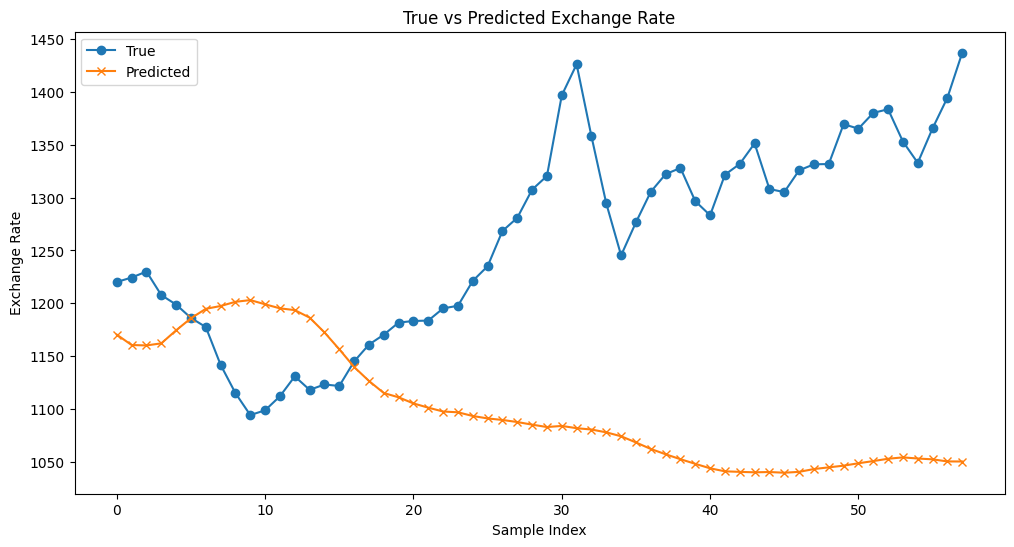

In [2]:
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. 랜덤 고정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2. 데이터 준비
df = pd.read_csv('/content/exchange_final.csv')
df_fill = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

all_features = [
    '경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
    '한국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
    '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격',
    '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '외국인 투자 금액',
    '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', '실질GDP',
    '실질GDP성장률', '한국 10년 채권수익률', '미국 10년 채권수익률', 'vix'
]

df_fill['원/달러환율_t+1'] = df_fill['원/달러환율'].shift(-1)
df_fill = df_fill.dropna(subset=all_features + ['원/달러환율_t+1']).reset_index(drop=True)
target = '원/달러환율_t+1'

# 3. 시퀀스 생성 함수
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# 4. 데이터 준비
X_full = df_fill[all_features].values
y_full = df_fill[target].values

seq_length = 12
X_seq, y_seq = create_sequences(X_full, y_full, seq_length)

split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

# 5. 전진 선택법
selected_features = []
best_r2 = -np.inf

while True:
    candidates = list(set(all_features) - set(selected_features))
    improvement = False
    best_candidate = None
    best_candidate_r2 = -np.inf

    for feature in candidates:
        current_features = selected_features + [feature]

        # 선택된 feature로 다시 데이터 만들기
        idx = [all_features.index(f) for f in current_features]

        # 스케일링
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        nsamples, timesteps, nfeatures = X_train_raw.shape
        X_train_2d = X_train_raw[:, :, idx].reshape((nsamples * timesteps, len(current_features)))
        X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, len(current_features)))
        y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

        # validation set 만들기
        split_val = int(len(X_train_scaled) * 0.9)
        X_train_final, X_val_final = X_train_scaled[:split_val], X_train_scaled[split_val:]
        y_train_final, y_val_final = y_train_scaled[:split_val], y_train_scaled[split_val:]

        # 모델 정의
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_final.shape[1], X_train_final.shape[2])),
            Dropout(0.2),
            GRU(32, return_sequences=True),
            Dropout(0.2),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])

        model.compile(loss='mse', optimizer='adam')
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(
            X_train_final, y_train_final,
            epochs=20, batch_size=16,
            validation_data=(X_val_final, y_val_final),
            callbacks=[early_stop],
            verbose=0
        )

        # 평가
        y_val_pred_scaled = model.predict(X_val_final, verbose=0)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_true = scaler_y.inverse_transform(y_val_final)

        r2 = r2_score(y_val_true, y_val_pred)

        if r2 > best_candidate_r2:
            best_candidate_r2 = r2
            best_candidate = feature

    if best_candidate_r2 > best_r2:
        selected_features.append(best_candidate)
        best_r2 = best_candidate_r2
        print(f"✅ 추가된 피처: {best_candidate}, 현재 R²: {best_r2:.4f}")
    else:
        break

print("\n🎯 최종 선택된 피처 리스트:")
for f in selected_features:
    print(f"- {f}")

# 6. 최종 모델 평가 (Test set)
idx = [all_features.index(f) for f in selected_features]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_2d = X_train_raw[:, :, idx].reshape((X_train_raw.shape[0]*X_train_raw.shape[1], len(selected_features)))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((X_train_raw.shape[0], X_train_raw.shape[1], len(selected_features)))

y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

X_test_2d = X_test_raw[:, :, idx].reshape((X_test_raw.shape[0]*X_test_raw.shape[1], len(selected_features)))
X_test_scaled = scaler_X.transform(X_test_2d).reshape((X_test_raw.shape[0], X_test_raw.shape[1], len(selected_features)))

y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 모델 재정의
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    GRU(16),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20, batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# 최종 예측
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# 최종 성능 출력
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n🎯 최종 모델 성능")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# 그래프
plt.figure(figsize=(12,6))
plt.plot(y_true, label='True', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('True vs Predicted Exchange Rate')
plt.xlabel('Sample Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# rmse 로 다시보기

✅ 추가된 피처: 실질GDP성장률, 현재 RMSE: 20.7570
✅ 추가된 피처: 한국 경상수지, 현재 RMSE: 18.4239
✅ 추가된 피처: 한국 실업률, 현재 RMSE: 16.7663
✅ 추가된 피처: 경제 심리 지수, 현재 RMSE: 15.8968

🎯 최종 선택된 피처 리스트:
- 실질GDP성장률
- 한국 경상수지
- 한국 실업률
- 경제 심리 지수

🎯 최종 모델 성능
R²: -4.2562
RMSE: 213.9286
MSE: 45765.4381
MAE: 181.6025


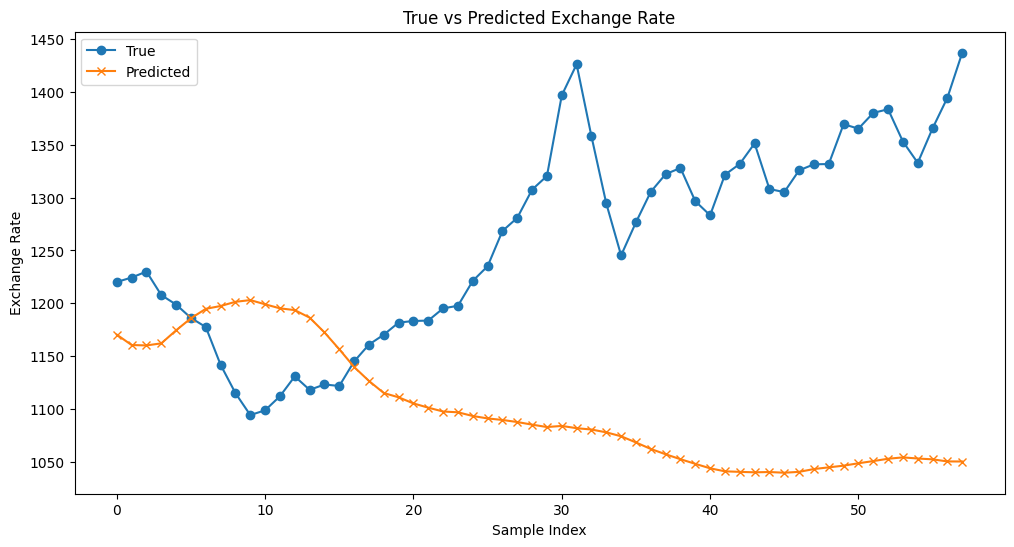

In [3]:
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. 랜덤 고정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2. 데이터 준비
df = pd.read_csv('/content/exchange_final.csv')
df_fill = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

all_features = [
    '경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
    '한국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
    '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격',
    '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '외국인 투자 금액',
    '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', '실질GDP',
    '실질GDP성장률', '한국 10년 채권수익률', '미국 10년 채권수익률', 'vix'
]

df_fill['원/달러환율_t+1'] = df_fill['원/달러환율'].shift(-1)
df_fill = df_fill.dropna(subset=all_features + ['원/달러환율_t+1']).reset_index(drop=True)
target = '원/달러환율_t+1'

# 3. 시퀀스 생성 함수
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# 4. 데이터 준비
X_full = df_fill[all_features].values
y_full = df_fill[target].values

seq_length = 12
X_seq, y_seq = create_sequences(X_full, y_full, seq_length)

split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

# 5. 전진 선택법
selected_features = []
best_rmse = np.inf

while True:
    candidates = list(set(all_features) - set(selected_features))
    improvement = False
    best_candidate = None
    best_candidate_rmse = np.inf

    for feature in candidates:
        current_features = selected_features + [feature]

        # 선택된 feature로 다시 데이터 만들기
        idx = [all_features.index(f) for f in current_features]

        # 스케일링
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        nsamples, timesteps, nfeatures = X_train_raw.shape
        X_train_2d = X_train_raw[:, :, idx].reshape((nsamples * timesteps, len(current_features)))
        X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, len(current_features)))
        y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

        # validation set 만들기
        split_val = int(len(X_train_scaled) * 0.9)
        X_train_final, X_val_final = X_train_scaled[:split_val], X_train_scaled[split_val:]
        y_train_final, y_val_final = y_train_scaled[:split_val], y_train_scaled[split_val:]

        # 모델 정의
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_final.shape[1], X_train_final.shape[2])),
            Dropout(0.2),
            GRU(32, return_sequences=True),
            Dropout(0.2),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])

        model.compile(loss='mse', optimizer='adam')
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(
            X_train_final, y_train_final,
            epochs=20, batch_size=16,
            validation_data=(X_val_final, y_val_final),
            callbacks=[early_stop],
            verbose=0
        )

        # 평가
        y_val_pred_scaled = model.predict(X_val_final, verbose=0)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_true = scaler_y.inverse_transform(y_val_final)

        rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

        if rmse < best_candidate_rmse:
            best_candidate_rmse = rmse
            best_candidate = feature

    if best_candidate_rmse < best_rmse:
        selected_features.append(best_candidate)
        best_rmse = best_candidate_rmse
        print(f"✅ 추가된 피처: {best_candidate}, 현재 RMSE: {best_rmse:.4f}")
    else:
        break

print("\n🎯 최종 선택된 피처 리스트:")
for f in selected_features:
    print(f"- {f}")

# 6. 최종 모델 평가 (Test set)
idx = [all_features.index(f) for f in selected_features]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_2d = X_train_raw[:, :, idx].reshape((X_train_raw.shape[0]*X_train_raw.shape[1], len(selected_features)))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((X_train_raw.shape[0], X_train_raw.shape[1], len(selected_features)))

y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

X_test_2d = X_test_raw[:, :, idx].reshape((X_test_raw.shape[0]*X_test_raw.shape[1], len(selected_features)))
X_test_scaled = scaler_X.transform(X_test_2d).reshape((X_test_raw.shape[0], X_test_raw.shape[1], len(selected_features)))

y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 모델 재정의
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    GRU(16),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20, batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# 최종 예측
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# 최종 성능 출력
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n🎯 최종 모델 성능")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# 그래프
plt.figure(figsize=(12,6))
plt.plot(y_true, label='True', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('True vs Predicted Exchange Rate')
plt.xlabel('Sample Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

🚀 A 모델 학습 시작
🎯 A 모델 최종 성능
R²: -4.0355
RMSE: 209.3885
MSE: 43843.5585
MAE: 173.2547


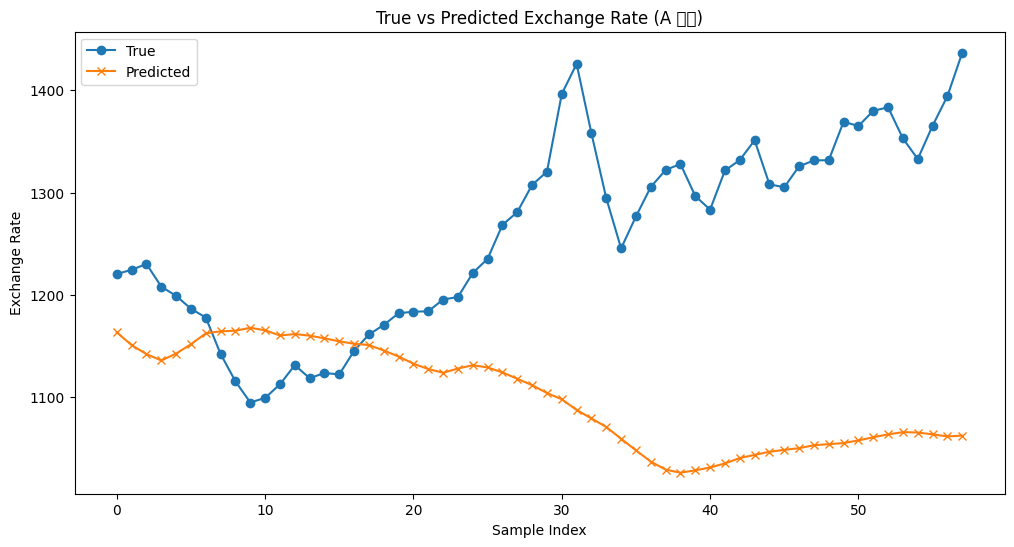

--------------------------------------------------
🚀 B 모델 학습 시작
🎯 B 모델 최종 성능
R²: -4.8766
RMSE: 226.2009
MSE: 51166.8348
MAE: 192.9245


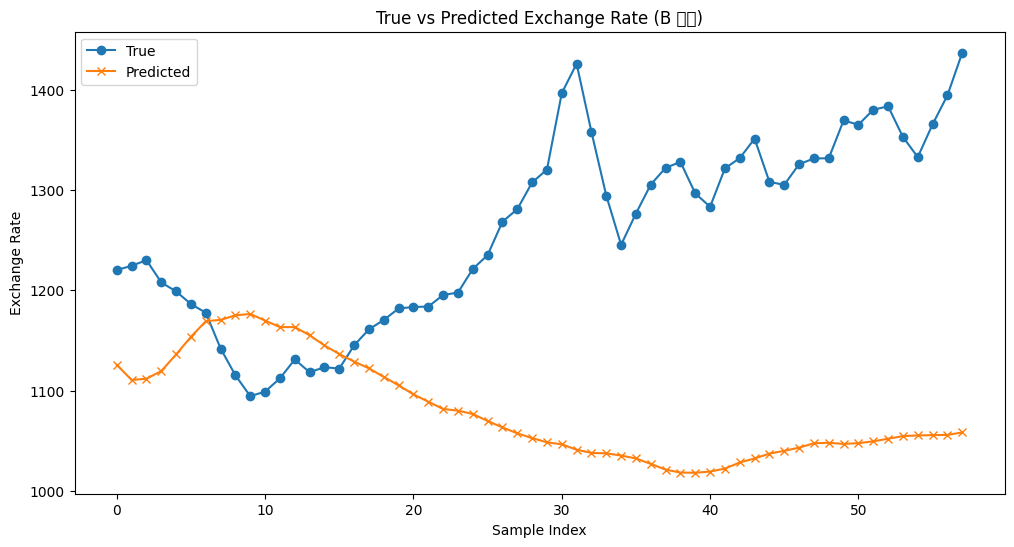

--------------------------------------------------
🚀 C 모델 학습 시작
🎯 C 모델 최종 성능
R²: -3.9610
RMSE: 207.8338
MSE: 43194.9059
MAE: 178.3607


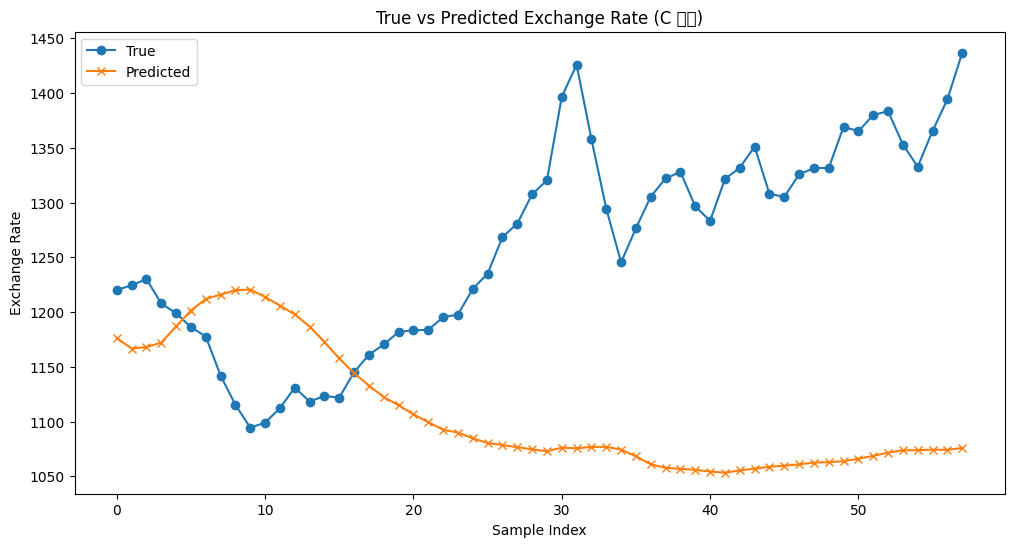

--------------------------------------------------
🚀 D 모델 학습 시작
🎯 D 모델 최종 성능
R²: -4.5426
RMSE: 219.6796
MSE: 48259.1415
MAE: 183.5286


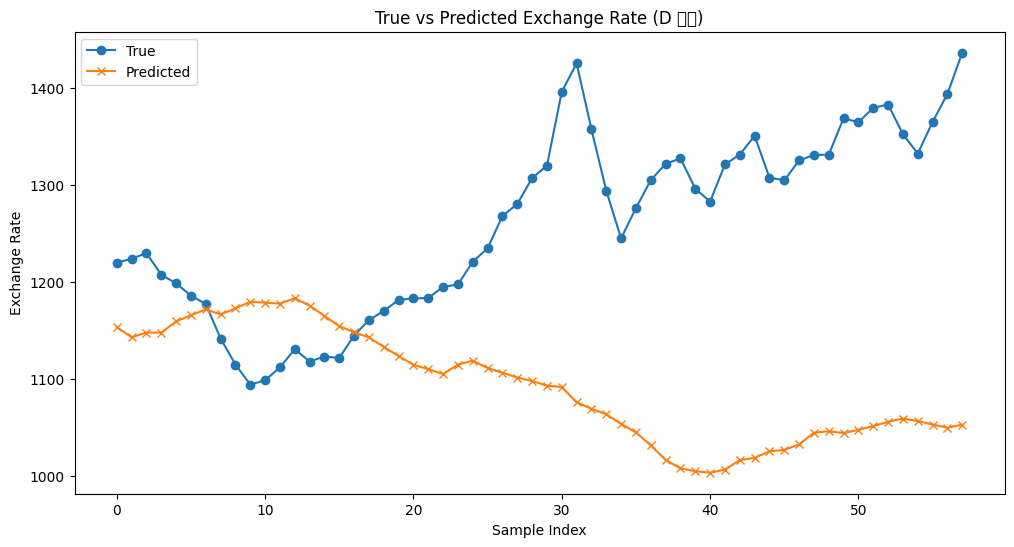

--------------------------------------------------


In [10]:
# 튜닝 버전별 모델 생성 함수
def build_model(version, input_shape):
    tf.random.set_seed(42)
    if version == 'A':
        model = Sequential([
            Bidirectional(GRU(32, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            GRU(16, return_sequences=True),
            Dropout(0.2),
            GRU(8),
            Dense(32, activation='relu'),
            Dense(1)
        ])

    elif version == 'B':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            GRU(64, return_sequences=True),
            Dropout(0.2),
            GRU(32),
            Dense(32, activation='relu'),
            Dense(1)
        ])

    elif version == 'C':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.3),
            GRU(32, return_sequences=True),
            Dropout(0.3),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])

    elif version == 'D':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            GRU(32),
            Dense(32, activation='relu'),
            Dense(1)
        ])

    else:
        raise ValueError("Invalid version name. Choose from ['A', 'B', 'C', 'D']")

    model.compile(optimizer='adam', loss='mse')
    return model

# 튜닝 및 평가 함수
def train_and_evaluate_model(version, X_train, y_train, X_test, y_test):
    print(f'🚀 {version} 모델 학습 시작')

    model = build_model(version, input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False  # ⭐ 추가!!!
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 {version} 모델 최종 성능")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프 추가!
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(f'True vs Predicted Exchange Rate ({version} 모델)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model


# X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled 사용
# A ~ D 버전 모두 실행
for version in ['A', 'B', 'C', 'D']:
    train_and_evaluate_model(version, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

### C버전이 그나마 나음 (Dropout 강화 버전)

기반으로 다시 튜닝

🚀 C1 모델 학습 시작
🎯 C1 모델 최종 성능
R²: -5.0045
RMSE: 228.6494
MSE: 52280.5414
MAE: 191.7292


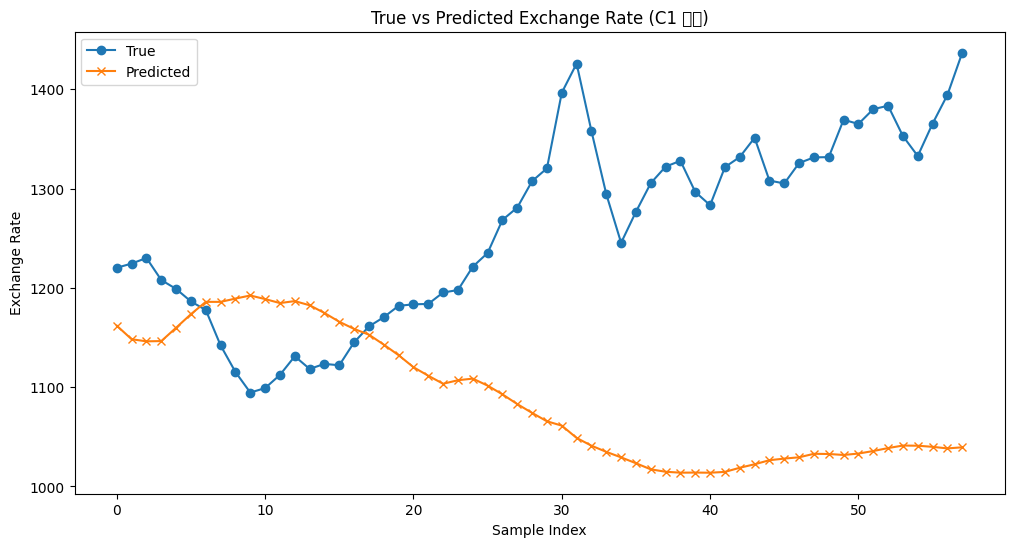

--------------------------------------------------
🚀 C2 모델 학습 시작
🎯 C2 모델 최종 성능
R²: -3.5363
RMSE: 198.7393
MSE: 39497.3057
MAE: 165.8923


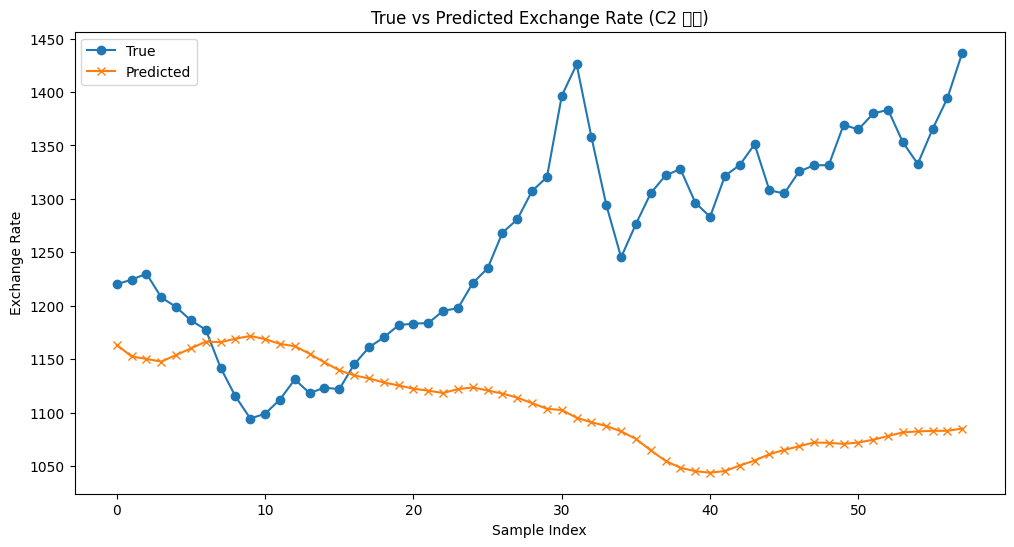

--------------------------------------------------
🚀 C3 모델 학습 시작
🎯 C3 모델 최종 성능
R²: -2.4306
RMSE: 172.8295
MSE: 29870.0514
MAE: 144.0536


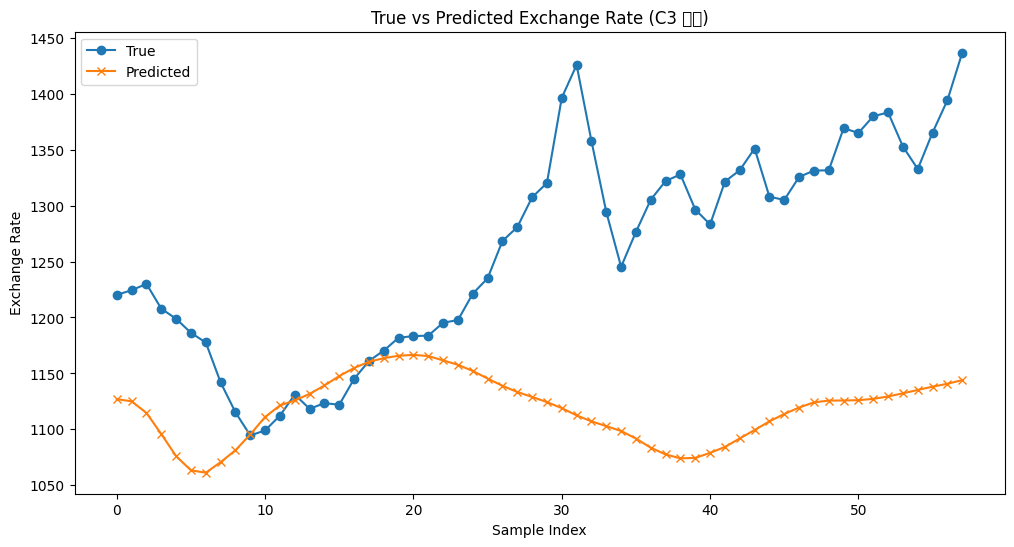

--------------------------------------------------
🚀 C4 모델 학습 시작
🎯 C4 모델 최종 성능
R²: -4.5758
RMSE: 220.3361
MSE: 48547.9956
MAE: 185.5572


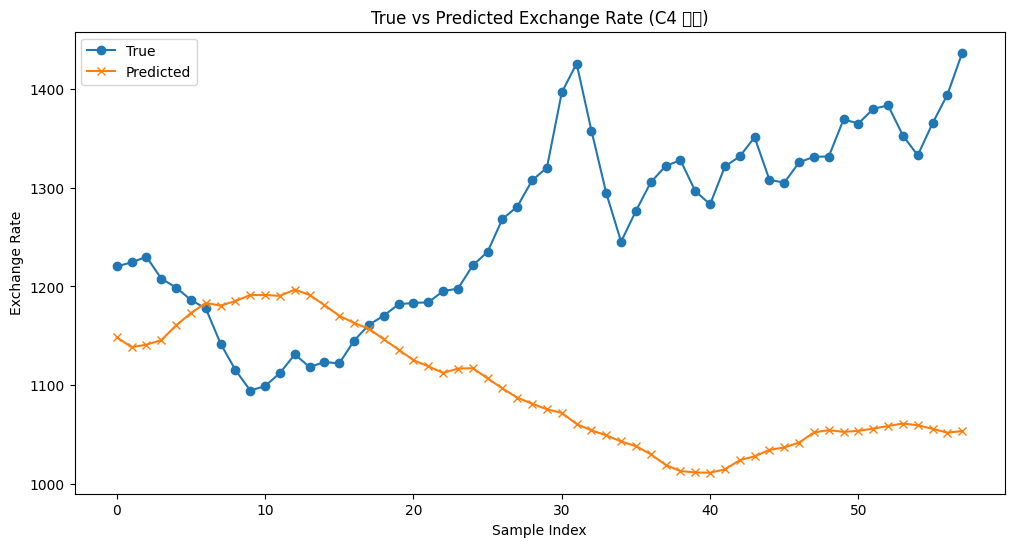

--------------------------------------------------
🚀 C5 모델 학습 시작
🎯 C5 모델 최종 성능
R²: -3.7020
RMSE: 202.3369
MSE: 40940.2103
MAE: 166.1435


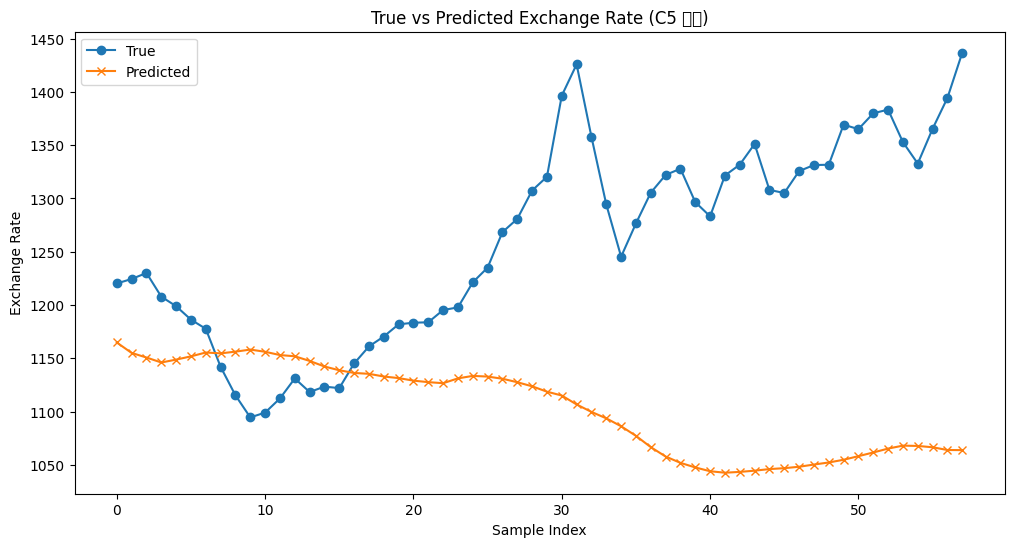

--------------------------------------------------


In [11]:
# 튜닝 버전별 모델 생성 함수 (추가 튜닝 버전)
def build_c_model(version, input_shape):
    tf.random.set_seed(42)  # 모델 만들 때도 시드 고정

    if version == 'C1':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.4),
            GRU(32, return_sequences=True),
            Dropout(0.4),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam()
        batch_size = 16
        epochs = 20

    elif version == 'C2':
        model = Sequential([
            Bidirectional(GRU(48, return_sequences=True), input_shape=input_shape),
            Dropout(0.3),
            GRU(24, return_sequences=True),
            Dropout(0.3),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam()
        batch_size = 16
        epochs = 20

    elif version == 'C3':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.3),
            GRU(32, return_sequences=True),
            Dropout(0.3),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam()
        batch_size = 32  # batch size 크게
        epochs = 20

    elif version == 'C4':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.3),
            GRU(32, return_sequences=True),
            Dropout(0.3),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # learning rate 낮춤
        batch_size = 16
        epochs = 20

    elif version == 'C5':
        model = Sequential([
            Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
            Dropout(0.3),
            GRU(32, return_sequences=True),
            Dropout(0.3),
            GRU(16),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam()
        batch_size = 16
        epochs = 40  # 에폭 증가

    else:
        raise ValueError("Invalid version name. Choose from ['C1', 'C2', 'C3', 'C4', 'C5']")

    model.compile(optimizer=optimizer, loss='mse')
    return model, batch_size, epochs

# 튜닝 및 평가 함수
def train_and_evaluate_c_model(version, X_train, y_train, X_test, y_test):
    print(f'🚀 {version} 모델 학습 시작')

    model, batch_size, epochs = build_c_model(version, input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False  # 랜덤 완전 고정
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 {version} 모델 최종 성능")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(f'True vs Predicted Exchange Rate ({version} 모델)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 여기까지 세팅한 후 ==========

# C1 ~ C5 버전 모두 실행
for version in ['C1', 'C2', 'C3', 'C4', 'C5']:
    train_and_evaluate_c_model(version, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### C3에 Learning Rate Decay 적용

🚀 C3 모델 (Learning Rate Decay 적용) 학습 시작
🎯 최종 성능 (C3 + Learning Rate Decay)
R²: -3.0704
RMSE: 188.2561
MSE: 35440.3498
MAE: 152.8329


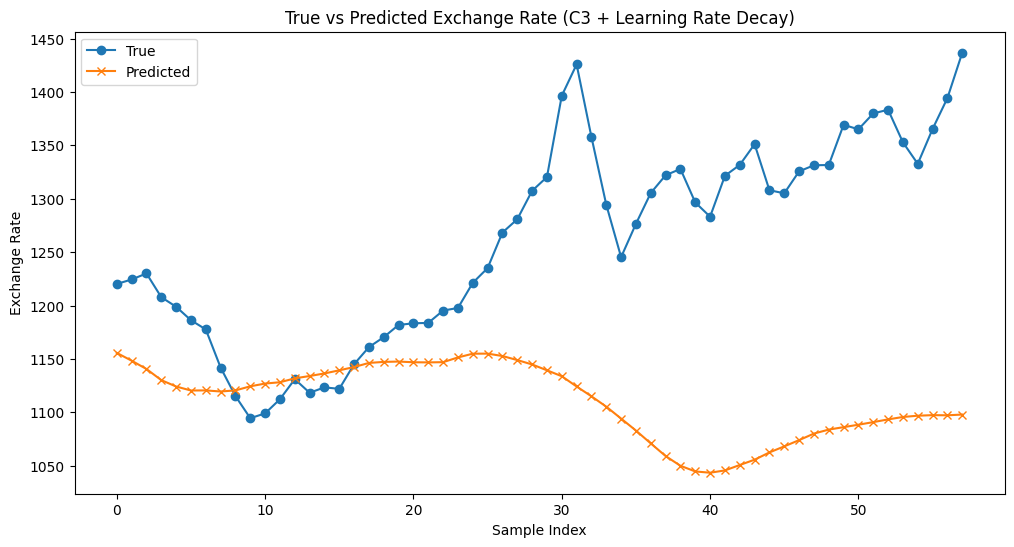

--------------------------------------------------


<Sequential name=sequential_330, built=True>

In [12]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 모델 생성 함수 (C3 기반)
def build_c3_with_lr_decay(input_shape):
    tf.random.set_seed(42)  # 모델 내부 랜덤 고정

    model = Sequential([
        Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        GRU(32, return_sequences=True),
        Dropout(0.3),
        GRU(16),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Learning Rate Scheduler
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,  # 시작 learning rate
        decay_steps=100,              # 몇 스텝마다 감소할지
        decay_rate=0.9,               # 감소 비율 (90%로 감소)
        staircase=True                # True면 깔끔하게 계단식으로 감소
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가 함수
def train_and_evaluate_c3_lr_decay(X_train, y_train, X_test, y_test):
    print(f'🚀 C3 모델 (Learning Rate Decay 적용) 학습 시작')

    model = build_c3_with_lr_decay(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=30,  # 조금 여유 있게 30까지 설정 (EarlyStopping 작동하니까 걱정 X)
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False  # 시드 완전 고정
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (C3 + Learning Rate Decay)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (C3 + Learning Rate Decay)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_c3_lr_decay(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### C3모델에서 Bidirectional GRU를 제거(과적합 방지)

🚀 C3 단방향 GRU 모델 학습 시작
🎯 최종 성능 (C3 단방향 GRU)
R²: -3.8415
RMSE: 205.3159
MSE: 42154.6014
MAE: 166.3180


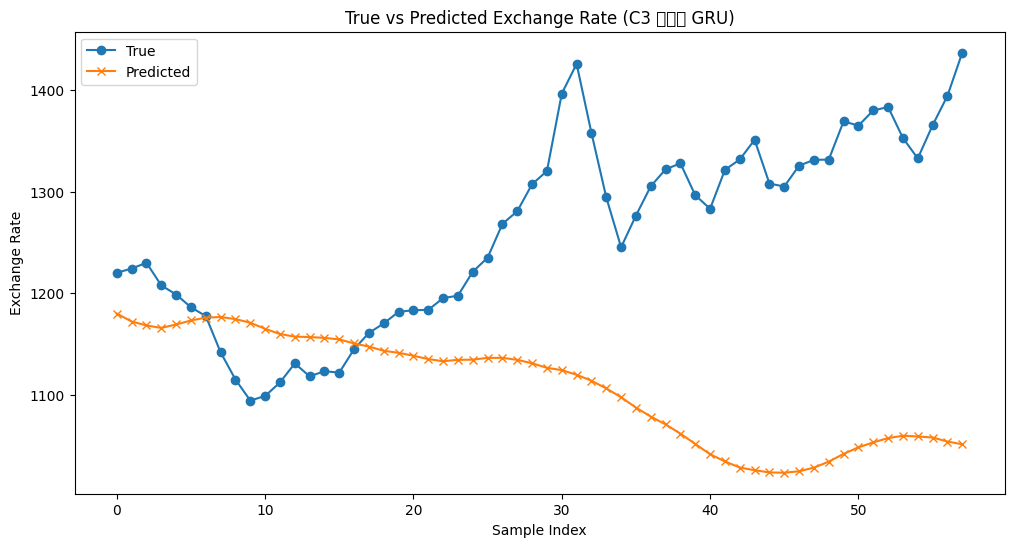

--------------------------------------------------


<Sequential name=sequential_331, built=True>

In [13]:
# 모델 생성 함수 (C3 기반 단방향 GRU 버전)
def build_c3_unidirectional(input_shape):
    tf.random.set_seed(42)  # 랜덤 고정

    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(32, return_sequences=True),
        Dropout(0.3),
        GRU(16),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가 함수
def train_and_evaluate_c3_unidirectional(X_train, y_train, X_test, y_test):
    print(f'🚀 C3 단방향 GRU 모델 학습 시작')

    model = build_c3_unidirectional(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (C3 단방향 GRU)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (C3 단방향 GRU)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_c3_unidirectional(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### Conv1D 추가

🚀 Conv1D + GRU 모델 학습 시작
🎯 최종 성능 (Conv1D + GRU)
R²: -3.6868
RMSE: 202.0083
MSE: 40807.3581
MAE: 168.6336


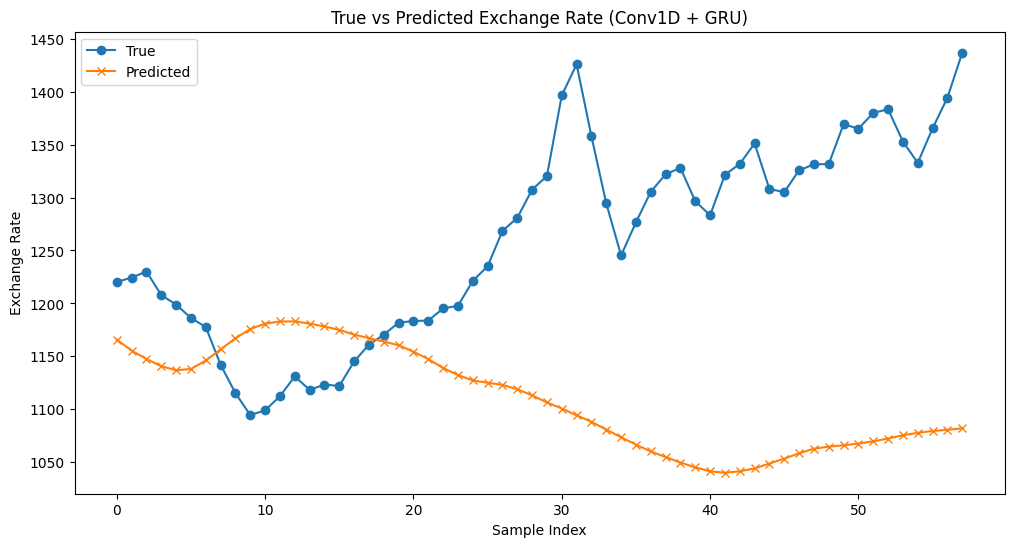

--------------------------------------------------


<Sequential name=sequential_332, built=True>

In [15]:
from tensorflow.keras.layers import Conv1D

# Conv1D + GRU 모델 생성 함수
def build_conv1d_gru_model(input_shape):
    tf.random.set_seed(42)  # 랜덤 고정

    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32, return_sequences=True),
        Dropout(0.3),
        GRU(16),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가 함수
def train_and_evaluate_conv1d_gru(X_train, y_train, X_test, y_test):
    print(f'🚀 Conv1D + GRU 모델 학습 시작')

    model = build_conv1d_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (Conv1D + GRU)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (Conv1D + GRU)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_conv1d_gru(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### Mini transformer

🚀 Mini Transformer 모델 학습 시작
🎯 최종 성능 (Mini Transformer)
R²: -1.1130
RMSE: 135.6380
MSE: 18397.6725
MAE: 117.1328


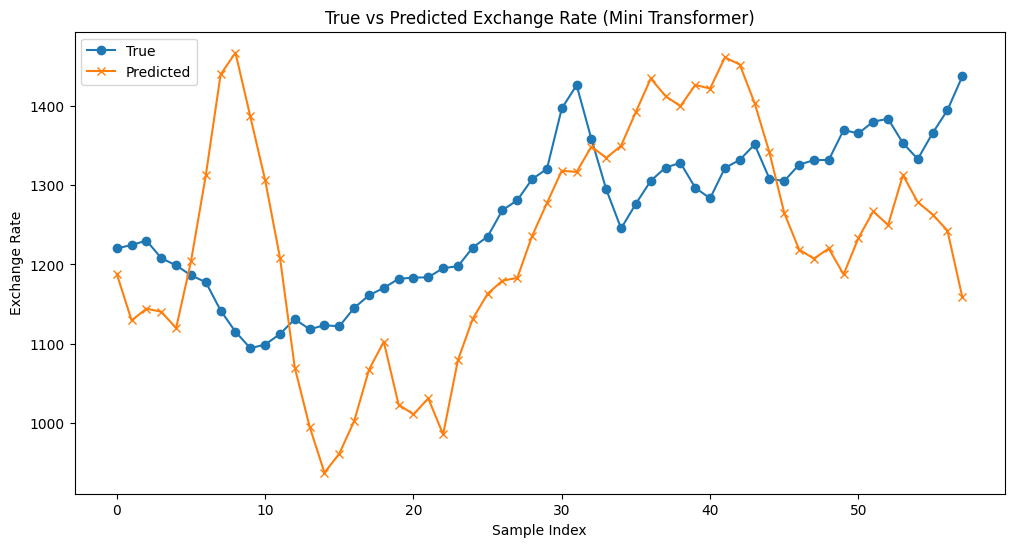

--------------------------------------------------


<Functional name=functional_343, built=True>

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 전체 Transformer 모델
def build_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    # Transformer 인코더 1층
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

    # Flatten 후 예측
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가 함수
def train_and_evaluate_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 Mini Transformer 모델 학습 시작')

    model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (Mini Transformer)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (Mini Transformer)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


🚀 Mini Transformer (개선버전 + 재현성 고정) 학습 시작
🎯 최종 성능 (개선된 Mini Transformer)
R²: -1.7336
RMSE: 154.2769
MSE: 23801.3490
MAE: 135.3642


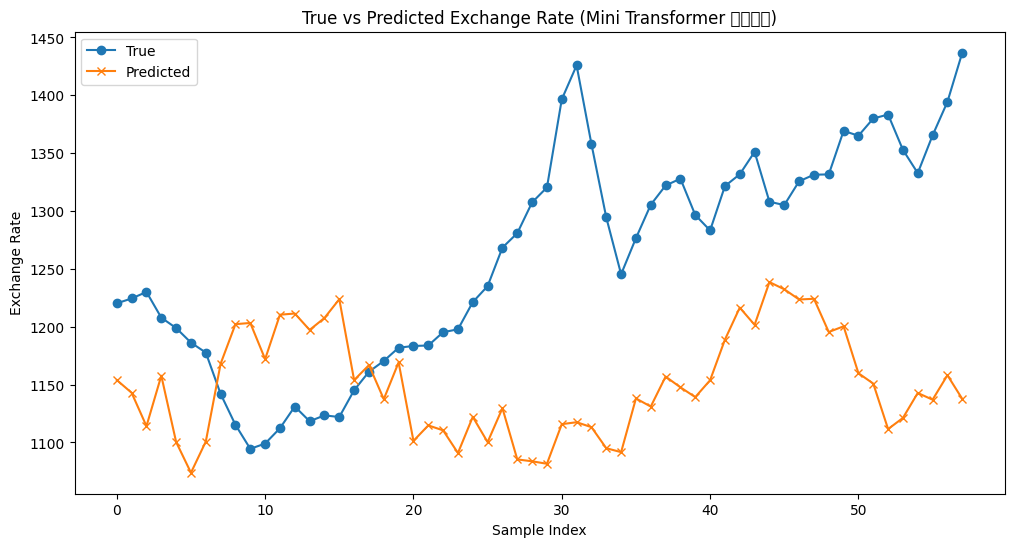

--------------------------------------------------


<Functional name=functional_341, built=True>

In [24]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 완전 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2. Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 3. 전체 모델 구성
def build_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 4. 학습 및 평가
def train_and_evaluate_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 Mini Transformer (개선버전 + 재현성 고정) 학습 시작')

    model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False  # ⭐ 반드시 고정
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (개선된 Mini Transformer)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (Mini Transformer 개선버전)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### 기본 Mini Transformer 버전 개선

🚀 Mini Transformer (미세 튜닝 버전) 학습 시작
🎯 최종 성능 (Mini Transformer 미세 튜닝)
R²: -3.8476
RMSE: 205.4454
MSE: 42207.8027
MAE: 166.2909


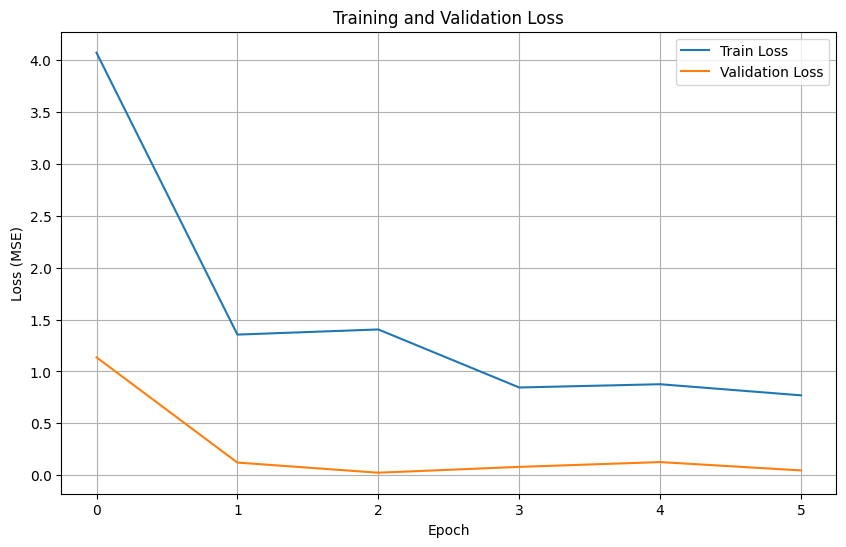

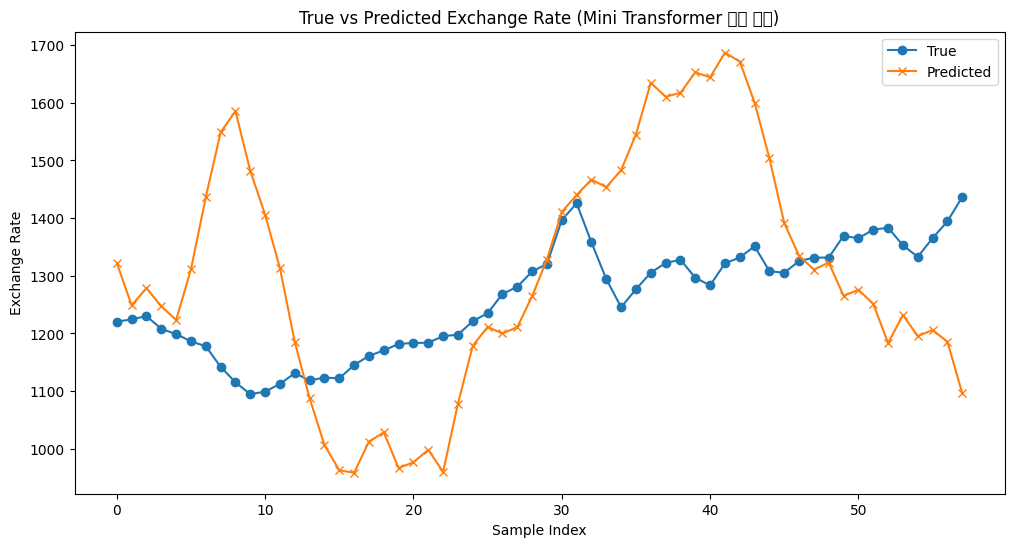

--------------------------------------------------


<Functional name=functional_344, built=True>

In [27]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 완전 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2. Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):  # ⭐ dropout 0.2로 변경
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 3. 전체 모델 구성
def build_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    # Transformer 2층 구성
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.2)
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.2)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # ⭐ learning rate 0.0005로 낮춤
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 4. 학습 및 평가
def train_and_evaluate_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 Mini Transformer (미세 튜닝 버전) 학습 시작')

    model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # ⭐ history 저장
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (Mini Transformer 미세 튜닝)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # ⭐ 추가: loss, val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (Mini Transformer 미세 튜닝)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### Mini Transformer 첫 버전 loss 그래프 다시확인

🚀 Mini Transformer (기본 버전) 학습 시작
🎯 최종 성능 (Mini Transformer 기본 버전)
R²: -1.1130
RMSE: 135.6380
MSE: 18397.6725
MAE: 117.1328


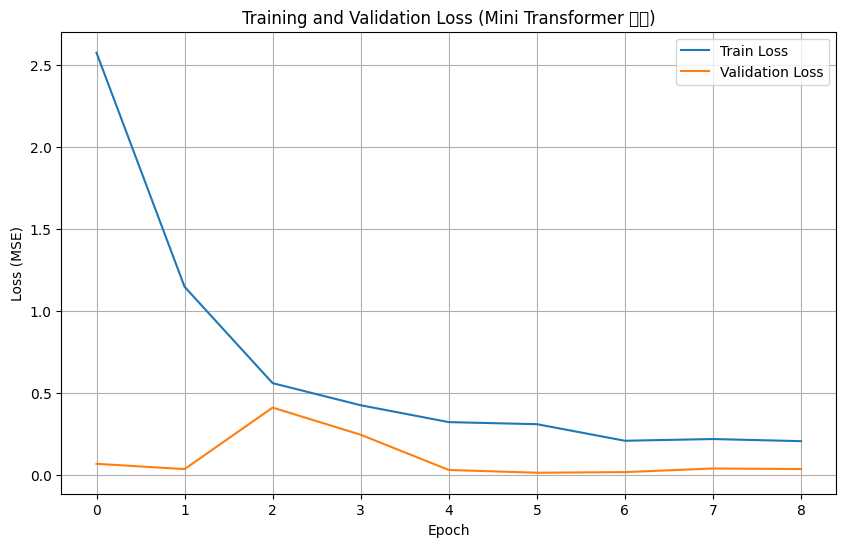

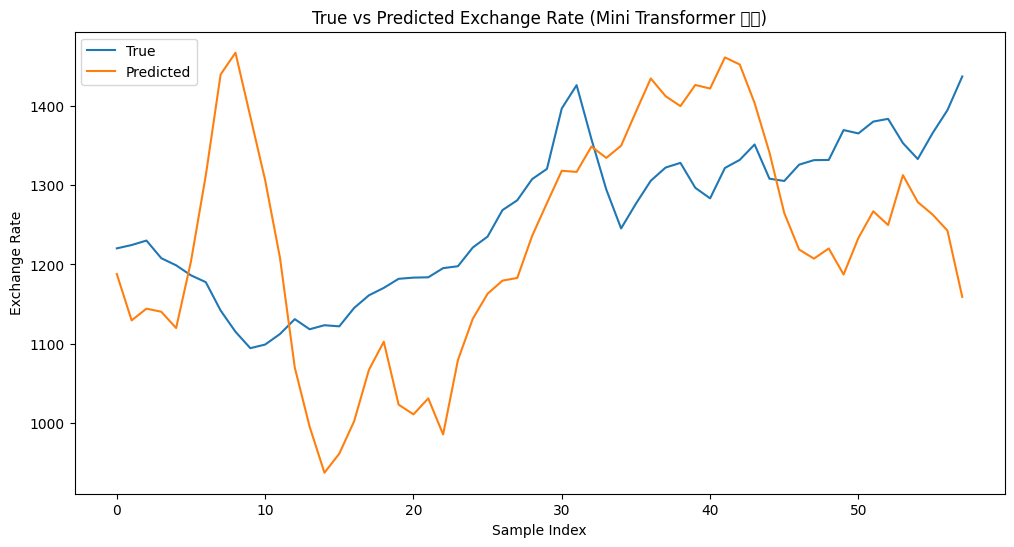

--------------------------------------------------


<Functional name=functional_346, built=True>

In [29]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 모델 구성
def build_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 Mini Transformer (기본 버전) 학습 시작')

    model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (Mini Transformer 기본 버전)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (Mini Transformer 기본)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title('True vs Predicted Exchange Rate (Mini Transformer 기본)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


# 너무 변수가 적은 것 아닐까?

후진제거법 사용한 변수 추가

In [31]:
# 1. 새로 선택된 18개 피처 리스트
selected_backward = [
    '경제 심리 지수', '한국 기준 금리', '한국 실업률', '한국 주가지수', '미국 주가지수',
    '두바이 유가', 'Brent 유가', '유연탄 가격', '철광석 가격', '니켈 가격',
    '금 가격', '옥수수 가격', '소맥 가격', '외국인 투자 금액',
    '인플레이션 격차', '실질GDP', '한국 10년 채권수익률', 'vix'
]

# 2. 새롭게 X, y 재구성
X_full_selected = df_fill[selected_backward].values
y_full = df_fill['원/달러환율_t+1'].values

# 3. 시퀀스 생성 함수 (기존과 동일)
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# 4. 시퀀스 생성
seq_length = 12  # 12개월
X_seq, y_seq = create_sequences(X_full_selected, y_full, seq_length)

# 5. 학습/테스트 분리
split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

# 6. 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# train
nsamples, timesteps, nfeatures = X_train_raw.shape
X_train_2d = X_train_raw.reshape((nsamples * timesteps, nfeatures))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, nfeatures))
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

# test
nsamples_test, _, _ = X_test_raw.shape
X_test_2d = X_test_raw.reshape((nsamples_test * timesteps, nfeatures))
X_test_scaled = scaler_X.transform(X_test_2d).reshape((nsamples_test, timesteps, nfeatures))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

print("✅ 새로운 18개 피처로 데이터 재구성 및 스케일링 완료!")
print(f"Train Shape: {X_train_scaled.shape}, Test Shape: {X_test_scaled.shape}")


✅ 새로운 18개 피처로 데이터 재구성 및 스케일링 완료!
Train Shape: (229, 12, 18), Test Shape: (58, 12, 18)


🚀 Mini Transformer (새로운 18개 피처) 학습 시작
🎯 최종 성능 (Mini Transformer + 18개 피처)
R²: -2.0805
RMSE: 163.7742
MSE: 26821.9855
MAE: 134.5942


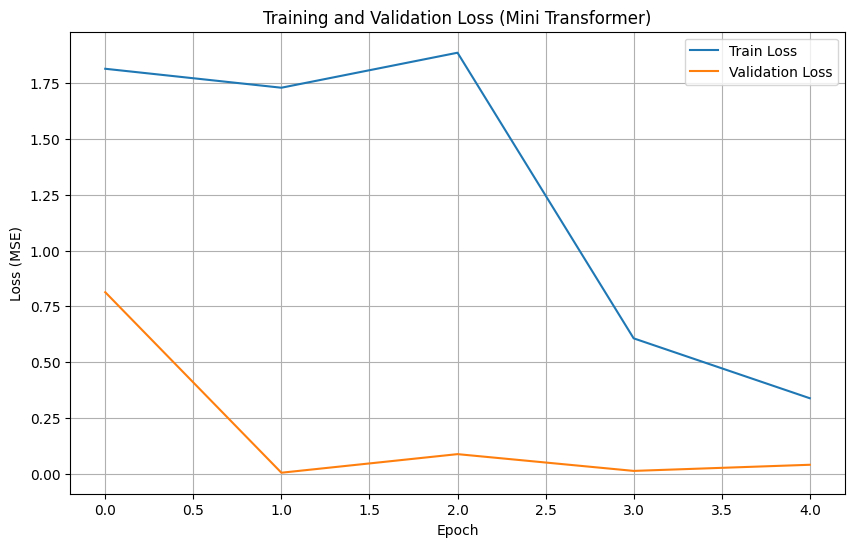

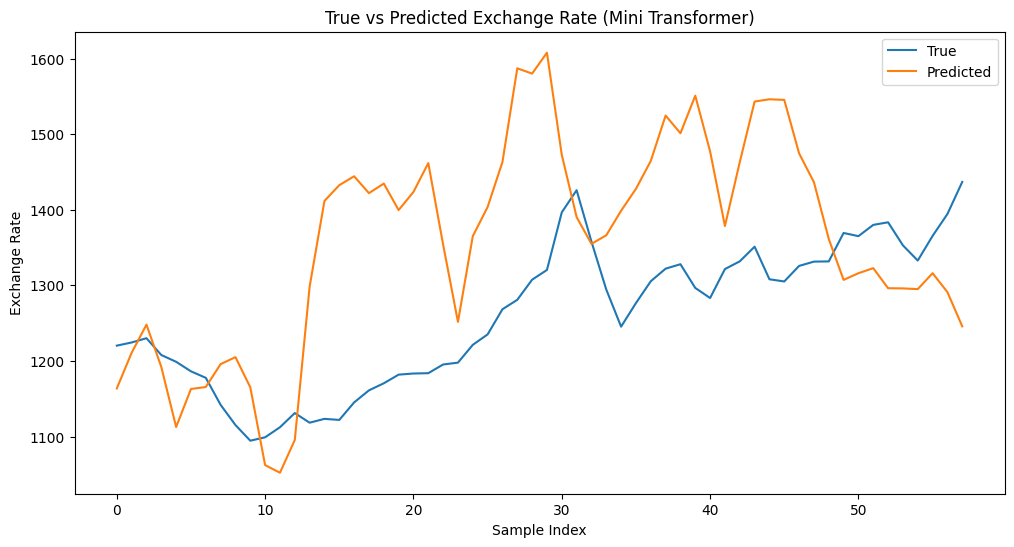

--------------------------------------------------


<Functional name=functional_347, built=True>

In [32]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 2. Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 3. 전체 모델 구성
def build_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    # Transformer 2층
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 4. 학습 및 평가
def train_and_evaluate_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 Mini Transformer (새로운 18개 피처) 학습 시작')

    model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (Mini Transformer + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # 5. loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (Mini Transformer)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 6. True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title('True vs Predicted Exchange Rate (Mini Transformer)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### 그대로 18개의 피처를 사용하고 mini Transfromer 모델 복잡도 강화

앞은 너무 얕아서 이 복잡한 구조를 못 따라갔음 (underfitting)

🚀 강화된 Mini Transformer (18개 피처) 학습 시작
🎯 최종 성능 (강화된 Mini Transformer + 18개 피처)
R²: -1.6916
RMSE: 153.0880
MSE: 23435.9442
MAE: 125.6159


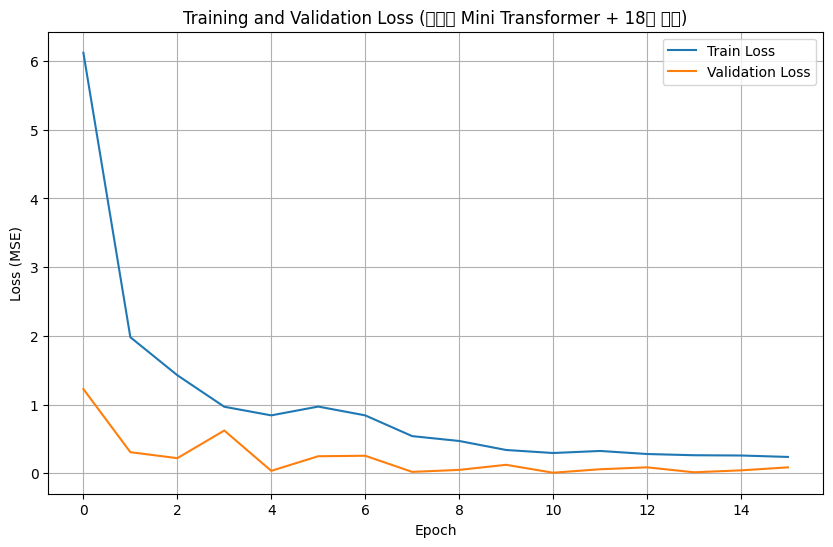

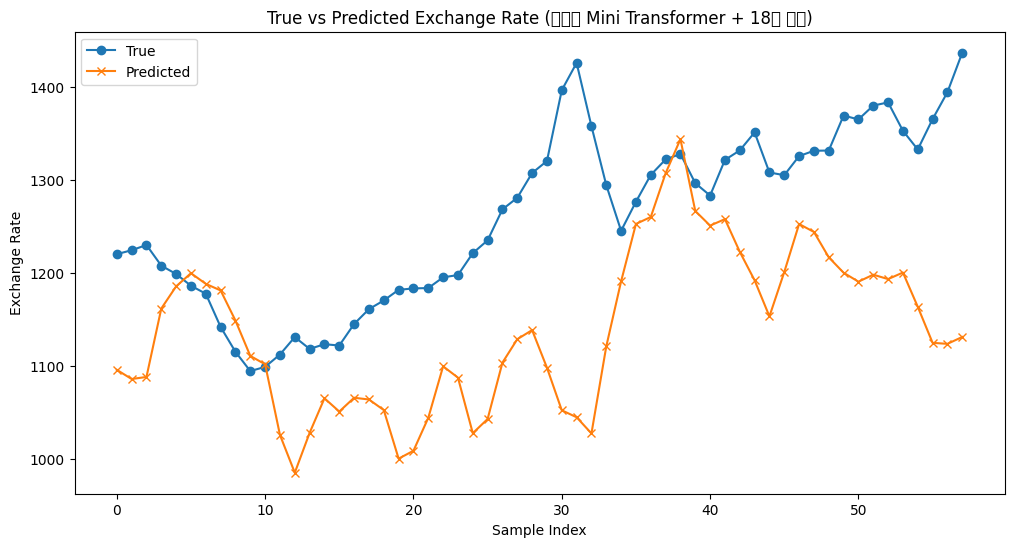

--------------------------------------------------


<Functional name=functional_348, built=True>

In [33]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 모델 구성
def build_big_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_big_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 강화된 Mini Transformer (18개 피처) 학습 시작')

    model = build_big_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (강화된 Mini Transformer + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (강화된 Mini Transformer + 18개 피처)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (강화된 Mini Transformer + 18개 피처)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_big_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### 모델 튜닝

Dropout 0.15	: 적절한 regularization 강화 (overfitting 방지)

EarlyStopping patience=7	: 충분히 학습 기회를 줘서 성능 향상 기회 늘림



🚀 튜닝된 강화 Mini Transformer (18개 피처) 학습 시작
🎯 최종 성능 (튜닝된 강화 Mini Transformer + 18개 피처)
R²: -1.3462
RMSE: 142.9287
MSE: 20428.6031
MAE: 117.9496


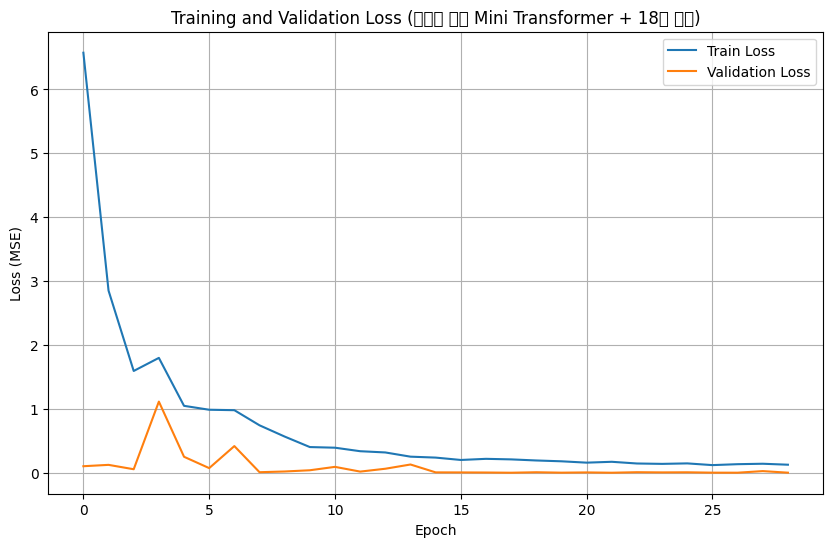

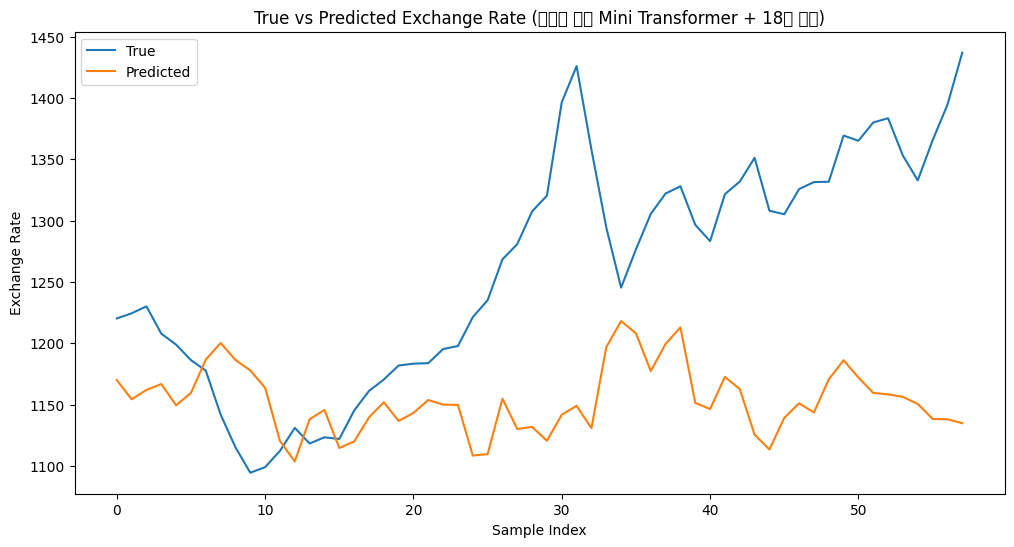

--------------------------------------------------


<Functional name=functional_352, built=True>

In [37]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Transformer Encoder Block (dropout 0.15로 수정)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.15):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 모델 구성
def build_finetuned_big_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # learning rate 0.001 유지
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_finetuned_big_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 튜닝된 강화 Mini Transformer (18개 피처) 학습 시작')

    model = build_finetuned_big_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # patience=7로 수정

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (튜닝된 강화 Mini Transformer + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (튜닝된 강화 Mini Transformer + 18개 피처)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title('True vs Predicted Exchange Rate (튜닝된 강화 Mini Transformer + 18개 피처)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_finetuned_big_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### (제일 괜찮음) 미세 튜닝

Learning rate 0.0007 + Dense(128) + Batch Size 16 조합으로 최종 미세 튜닝

항목 | 수정
---|----
Dropout | 0.15 (유지)
Learning Rate | 0.0007 (미세 감소)
Dense 노드 수 | 128
Batch Size | 16
EarlyStopping patience | 7

🚀 최종 미세 튜닝된 강화 Mini Transformer (18개 피처) 학습 시작
🎯 최종 성능 (최종 미세 튜닝된 강화 Mini Transformer + 18개 피처)
R²: -0.2091
RMSE: 102.6051
MSE: 10527.8114
MAE: 83.4476


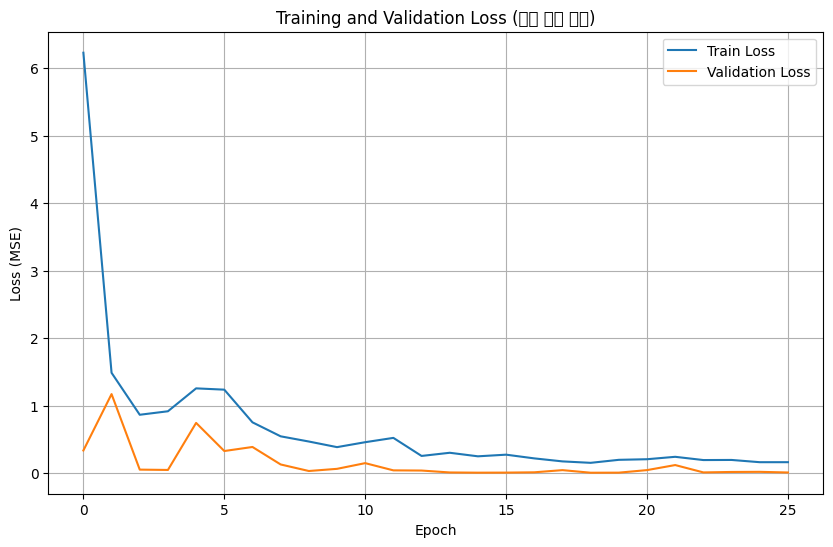

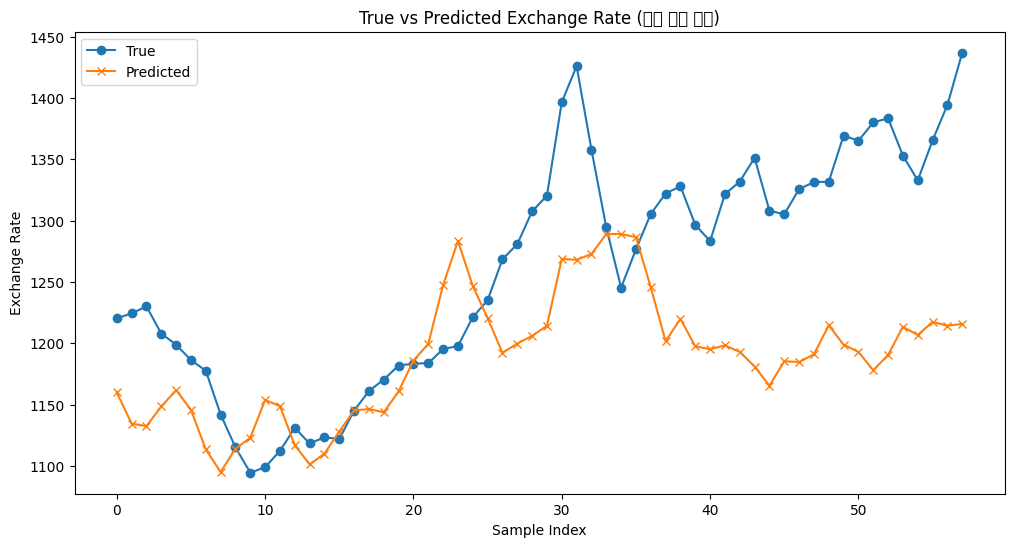

--------------------------------------------------


<Functional name=functional_355, built=True>

In [45]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 시드 고정
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Transformer Encoder Block (Dropout 0.15)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.15):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 모델 구성 (Dense(128)로 강화)
def build_super_finetuned_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  # ⭐ Dense 128로 증가
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)  # ⭐ Learning rate 0.0007
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_super_finetuned_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 최종 미세 튜닝된 강화 Mini Transformer (18개 피처) 학습 시작')

    model = build_super_finetuned_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,  # ⭐ Batch Size 16
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (최종 미세 튜닝된 강화 Mini Transformer + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (최종 미세 튜닝)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (최종 미세 튜닝)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_super_finetuned_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


### 시퀀스 6으로 변경

In [39]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# (1) X, y 준비
X = df_fill[selected_backward]  # 18개 피처
y = df_fill['원/달러환율_t+1']   # 예측 타겟

# (2) 시퀀스 생성 함수 (seq_length=6)
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

# (3) 시퀀스 생성
seq_length = 6
X_seq, y_seq = create_sequences(X.values, y.values, seq_length)

print(f"✅ 시퀀스 6개로 생성 완료! X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

# (4) Train/Test Split
split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train_raw, y_test_raw = y_seq[:split], y_seq[split:]

# (5) 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# train
nsamples, timesteps, nfeatures = X_train_raw.shape
X_train_2d = X_train_raw.reshape((nsamples * timesteps, nfeatures))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape((nsamples, timesteps, nfeatures))
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))

# test
nsamples_test, _, _ = X_test_raw.shape
X_test_2d = X_test_raw.reshape((nsamples_test * timesteps, nfeatures))
X_test_scaled = scaler_X.transform(X_test_2d).reshape((nsamples_test, timesteps, nfeatures))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

print(f"✅ 스케일링 완료! X_train_scaled shape: {X_train_scaled.shape}, X_test_scaled shape: {X_test_scaled.shape}")

✅ 시퀀스 6개로 생성 완료! X_seq shape: (293, 6, 18), y_seq shape: (293,)
✅ 스케일링 완료! X_train_scaled shape: (234, 6, 18), X_test_scaled shape: (59, 6, 18)


### 최종 개선된 Mini Transformer 모델

(Dropout 0.15, Dense(128), BatchSize 16, LearningRate 0.0007)

🚀 최종 미세 튜닝 + 시퀀스 6 Mini Transformer 학습 시작
🎯 최종 성능 (시퀀스 6 Mini Transformer)
R²: -4.1065
RMSE: 209.9162
MSE: 44064.8285
MAE: 173.4198


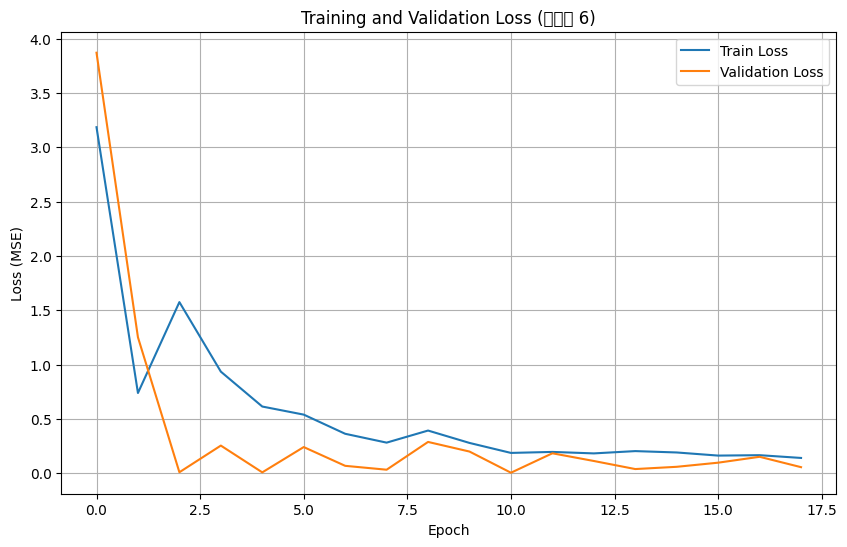

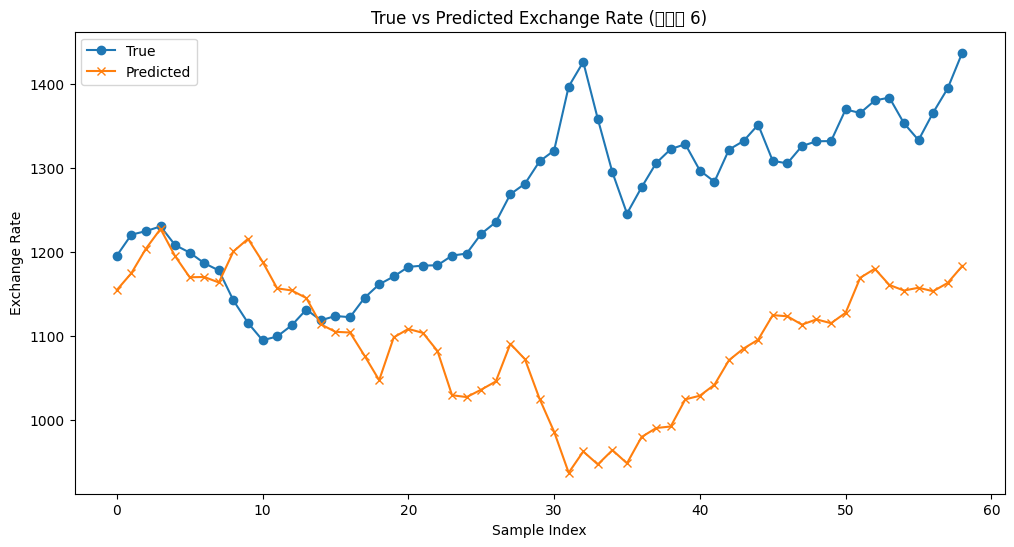

--------------------------------------------------


<Functional name=functional_354, built=True>

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.15):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# 모델 구성
def build_seq6_transformer_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.15)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_seq6_transformer(X_train, y_train, X_test, y_test):
    print(f'🚀 최종 미세 튜닝 + 시퀀스 6 Mini Transformer 학습 시작')

    model = build_seq6_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (시퀀스 6 Mini Transformer)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (시퀀스 6)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (시퀀스 6)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_seq6_transformer(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


-> 시퀀스 6결과 좋지 않음 다시 위의 시퀀스 12 적용

### LSTM

🚀 LSTM 모델 (18개 피처, 시퀀스 12) 학습 시작
🎯 최종 성능 (LSTM + 18개 피처)
R²: -0.4531
RMSE: 112.4804
MSE: 12651.8427
MAE: 91.3964


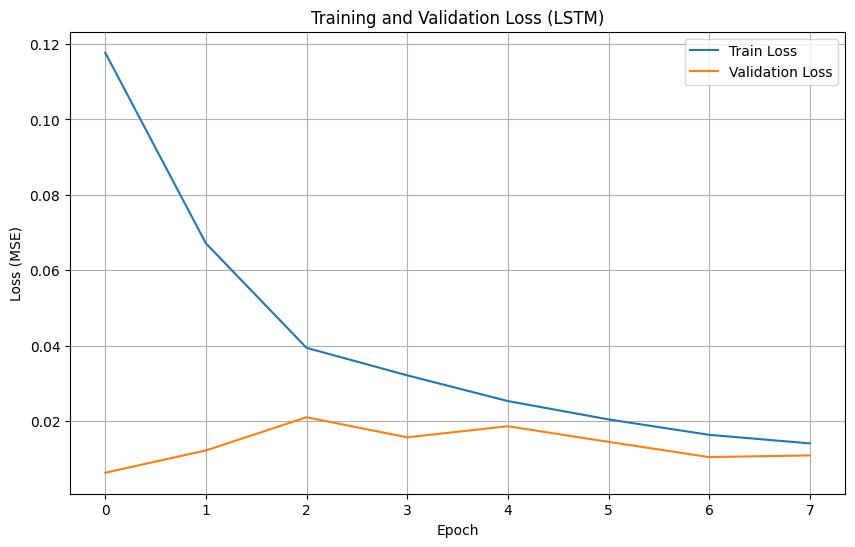

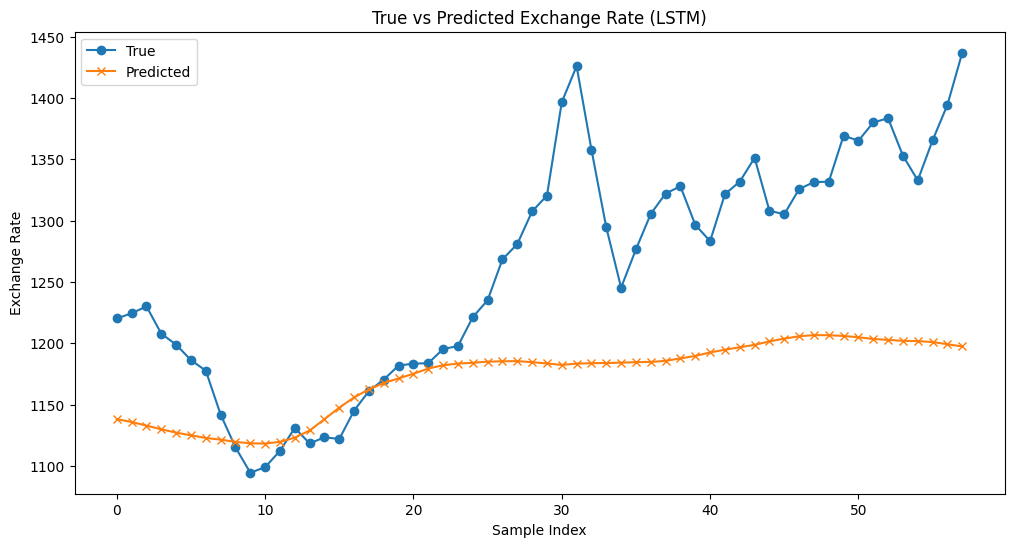

--------------------------------------------------


<Functional name=functional_356, built=True>

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 구성
def build_lstm_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test):
    print(f'🚀 LSTM 모델 (18개 피처, 시퀀스 12) 학습 시작')

    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (LSTM + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (LSTM)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (LSTM)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


#### LSTM 개선

LSTM을 3층 (64 → 32 → 16)으로 깊게 쌓아서

Dense(256) 레이어로 복잡한 피처 조합을 학습

Dropout 0.1로 regularization은 가볍게 적용

Adam(learning_rate=0.001)로 부드럽고 빠른 최적화

🚀 최적화된 LSTM 모델 (18개 피처, 시퀀스 12) 학습 시작
🎯 최종 성능 (최적화된 LSTM + 18개 피처)
R²: -0.2456
RMSE: 104.1426
MSE: 10845.6809
MAE: 86.2073


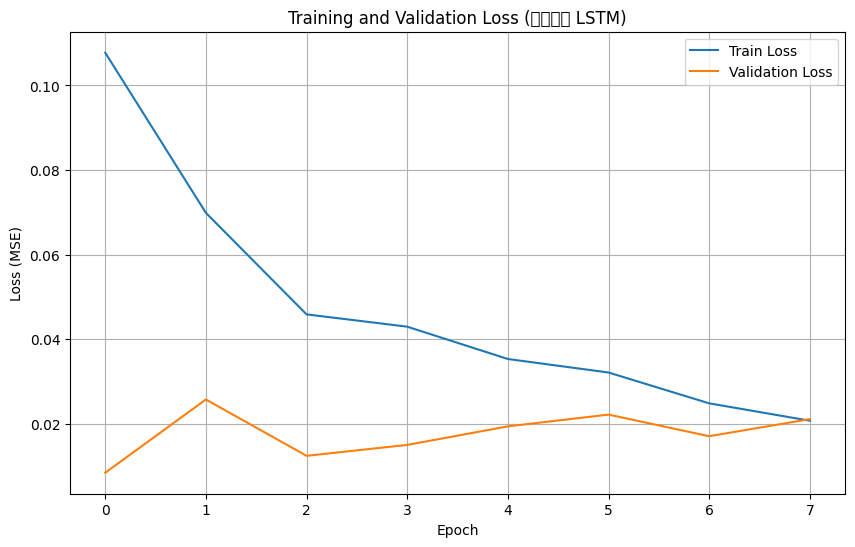

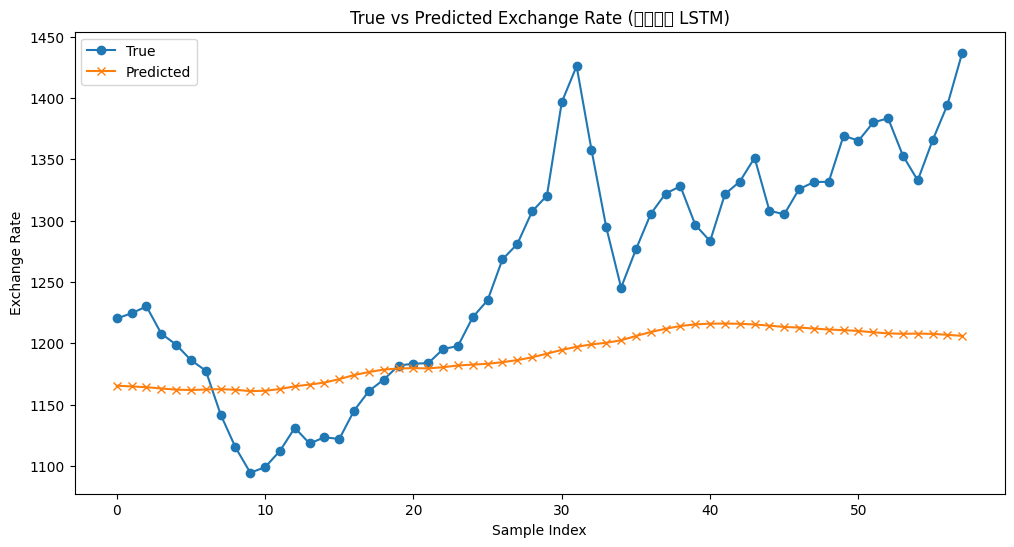

--------------------------------------------------


<Functional name=functional_359, built=True>

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 구성
def build_optimized_lstm_model(input_shape):
    tf.random.set_seed(42)

    inputs = Input(shape=input_shape)

    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.1)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = LSTM(16)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# 학습 및 평가
def train_and_evaluate_optimized_lstm(X_train, y_train, X_test, y_test):
    print(f'🚀 최적화된 LSTM 모델 (18개 피처, 시퀀스 12) 학습 시작')

    model = build_optimized_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    # 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # 평가
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"🎯 최종 성능 (최적화된 LSTM + 18개 피처)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # loss vs val_loss 그래프
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (최적화된 LSTM)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # True vs Predicted 그래프
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title('True vs Predicted Exchange Rate (최적화된 LSTM)')
    plt.xlabel('Sample Index')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

    print('-'*50)

    return model

# ========== 실행 ==========

train_and_evaluate_optimized_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
